**Capstone Project**

The following code will clean up drug product information. The data was downloaded as a .csv and then uploaded to GitHub as a .txt from the following link: https://www.kaggle.com/datasets/maheshdadhich/us-healthcare-data/data?select=Drugs_product.csv

This notebook will do exploration of potential app options. 


In [106]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import plotly.graph_objects as go

In [107]:
#Raw file url for the upload
url = 'https://raw.githubusercontent.com/adevin2/ADevin_Capstone/main/Drugs_product.csv'

#Had to specify the encoding because errors
df = pd.read_csv(url, encoding='ISO-8859-1')

print(df.head())

                                        PRODUCTID PRODUCTNDC  \
0  0002-1200_4bd46cbe-cdc1-4329-a8e7-22816bd7fc33  0002-1200   
1  0002-1407_14757f9d-f641-4836-acf3-229265588d1d  0002-1407   
2  0002-1433_aaae85ae-9295-465f-b938-463b74b8d5bd  0002-1433   
3  0002-1434_aaae85ae-9295-465f-b938-463b74b8d5bd  0002-1434   
4  0002-1445_2ecde4c5-5128-4725-9cf5-64384857eb1c  0002-1445   

           PRODUCTTYPENAME      PROPRIETARYNAME PROPRIETARYNAMESUFFIX  \
0  HUMAN PRESCRIPTION DRUG               Amyvid                   NaN   
1  HUMAN PRESCRIPTION DRUG  Quinidine Gluconate                   NaN   
2  HUMAN PRESCRIPTION DRUG            Trulicity                   NaN   
3  HUMAN PRESCRIPTION DRUG            Trulicity                   NaN   
4  HUMAN PRESCRIPTION DRUG                TALTZ                   NaN   

    NONPROPRIETARYNAME       DOSAGEFORMNAME     ROUTENAME  STARTMARKETINGDATE  \
0     Florbetapir F 18  INJECTION, SOLUTION   INTRAVENOUS          20120601.0   
1  Quinidine G

In [108]:
#Delete columns for: DEA schedule, Pharm Classes, Active Ingredient Unit, Active Numerator Strength, Propreitary Name Suffix, End Market Date, Labeler Name, and Application Number
#This information is not of interest to explore
df_cleaned = df.drop(columns=['DEASCHEDULE', 'PHARM_CLASSES', 'ACTIVE_INGRED_UNIT', 
                              'ACTIVE_NUMERATOR_STRENGTH', 'PROPRIETARYNAMESUFFIX', 'APPLICATIONNUMBER', 'ENDMARKETINGDATE', 'LABELERNAME'])

#Filter the data to only include over-the-counter (OTC) medication
df_filtered = df_cleaned[df_cleaned['PRODUCTTYPENAME'] == 'HUMAN OTC DRUG']

#Count number NaN Start Marketing Date
count_nan_start_date = df_filtered['STARTMARKETINGDATE'].isna().sum()
print(f"Number of datasets with NaN for STARTMARKETINGDATE before cleanup: {count_nan_start_date}")

#Remove any that have no marketing start date as they are technically not on the market so not relevant to this
df_filtered = df_filtered.dropna(subset=['STARTMARKETINGDATE'])

#Confirm they have all been deleted
count_nan_start_date = df_filtered['STARTMARKETINGDATE'].isna().sum()
print(f"Number of datasets with NaN for STARTMARKETINGDATE after cleanup: {count_nan_start_date}")

#Convert the Start Marketing Date to readable date format
df_filtered['STARTMARKETINGDATE'] = pd.to_datetime(df_filtered['STARTMARKETINGDATE'].astype(int).astype(str), format='%Y%m%d', errors='coerce')

#Remove anything after the "," or ";" for DosageFormName and Route Name as we are not concerned with details, just the general dose form
df_filtered['DOSAGEFORMNAME'] = df_filtered['DOSAGEFORMNAME'].str.split('[,;]').str[0]
df_filtered['ROUTENAME'] = df_filtered['ROUTENAME'].str.split('[,;]').str[0]
print(df_filtered.head())


Number of datasets with NaN for STARTMARKETINGDATE before cleanup: 5
Number of datasets with NaN for STARTMARKETINGDATE after cleanup: 0
                                         PRODUCTID PRODUCTNDC PRODUCTTYPENAME  \
67  0002-8215_08827443-2aa4-4cd9-9657-64a52085fd83  0002-8215  HUMAN OTC DRUG   
68  0002-8315_96565fb7-dbd9-4048-96a7-73e9c3626f6e  0002-8315  HUMAN OTC DRUG   
71  0002-8715_adccb1d5-7fb9-48d1-8dd9-e2a0a6a8a735  0002-8715  HUMAN OTC DRUG   
75  0002-8803_adccb1d5-7fb9-48d1-8dd9-e2a0a6a8a735  0002-8803  HUMAN OTC DRUG   
76  0002-8805_96565fb7-dbd9-4048-96a7-73e9c3626f6e  0002-8805  HUMAN OTC DRUG   

   PROPRIETARYNAME NONPROPRIETARYNAME DOSAGEFORMNAME     ROUTENAME  \
67         Humulin      Insulin human      INJECTION    PARENTERAL   
68         Humulin      Insulin human      INJECTION  SUBCUTANEOUS   
71         Humulin      Insulin human      INJECTION  SUBCUTANEOUS   
75         Humulin      Insulin human      INJECTION  SUBCUTANEOUS   
76         Humulin      In

Now that the data is cleaned with only the columns of potential interest, we can do some preliminary plots to see what potential exploration can be done. 

**Exploring OTC Drug Products per Year**

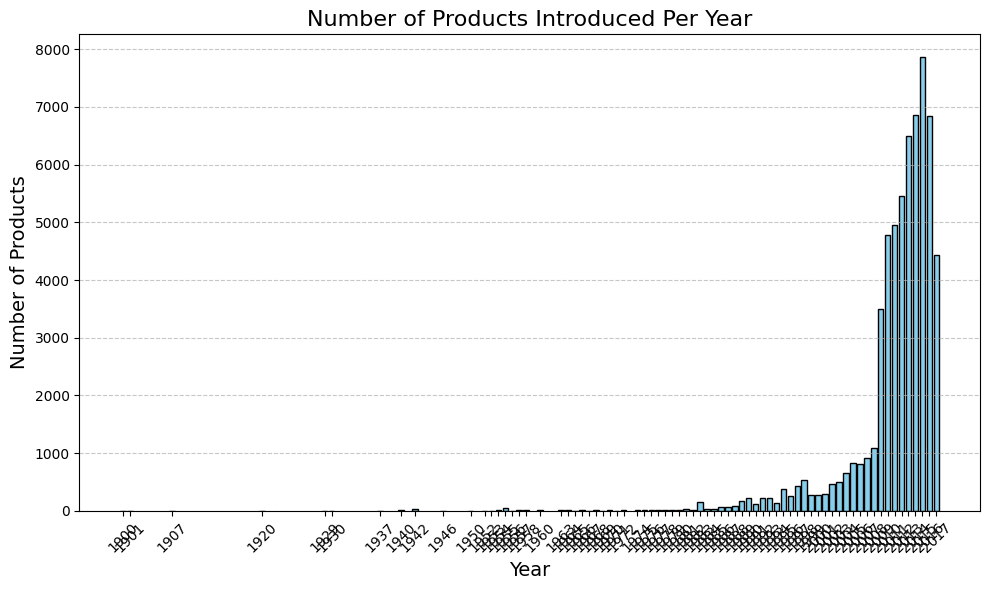

In [109]:
#Extract the year from STARTMARKETINGDATE
df_filtered['Year'] = df_filtered['STARTMARKETINGDATE'].dt.year

#Count the number of products per year
products_per_year = df_filtered['Year'].value_counts().sort_index()

#Plot the data
plt.figure(figsize=(10, 6))
plt.bar(products_per_year.index, products_per_year.values, color='skyblue', edgecolor='black')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.title('Number of Products Introduced Per Year', fontsize=16)
plt.xticks(products_per_year.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Given the plot above, this would be fun to explore how a linear regression model could predict the number of OTC drugs available per year in future years. Though it will likely be off due to the dip in recent years. 

Mean Squared Error (MSE): 1689981.65
Mean Absolute Error (MAE): 1061.79


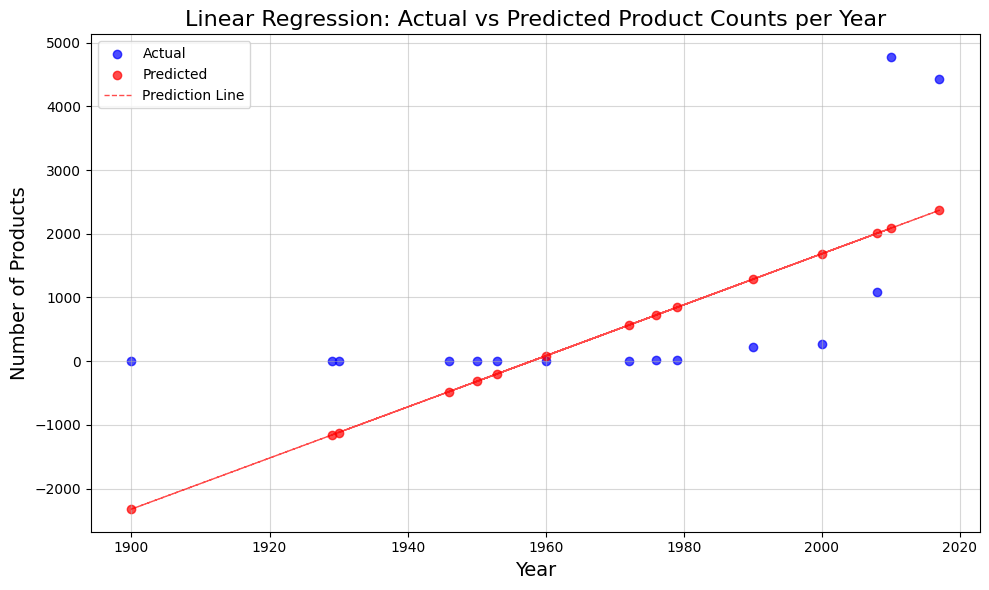

Intercept: -78494.78
Coefficient (slope): 40.09


In [110]:
#Preparing data in a cleaner way 
products_per_year_df = products_per_year.reset_index()  #Resetting index
products_per_year_df.columns = ['Year', 'Product_Count']  #Renaming columns

X = products_per_year_df[['Year']]  #Independent variable
y = products_per_year_df['Product_Count']  #Dependent variable

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% train, 20% test

#Train
model = LinearRegression()
model.fit(X_train, y_train)

#Make Predictions
y_pred = model.predict(X_test)

#Evaluate using MSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

#Visualize Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.7)
plt.plot(X_test, y_pred, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Prediction Line')
plt.title("Linear Regression: Actual vs Predicted Product Counts per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Products", fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

#Display model coefficients
print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficient (slope): {model.coef_[0]:.2f}")

As assumed, it is quite off. Taking the log in order to accounted for skewed numbers. 

Mean Squared Error (MSE): 1.86
Mean Absolute Error (MAE): 1.10


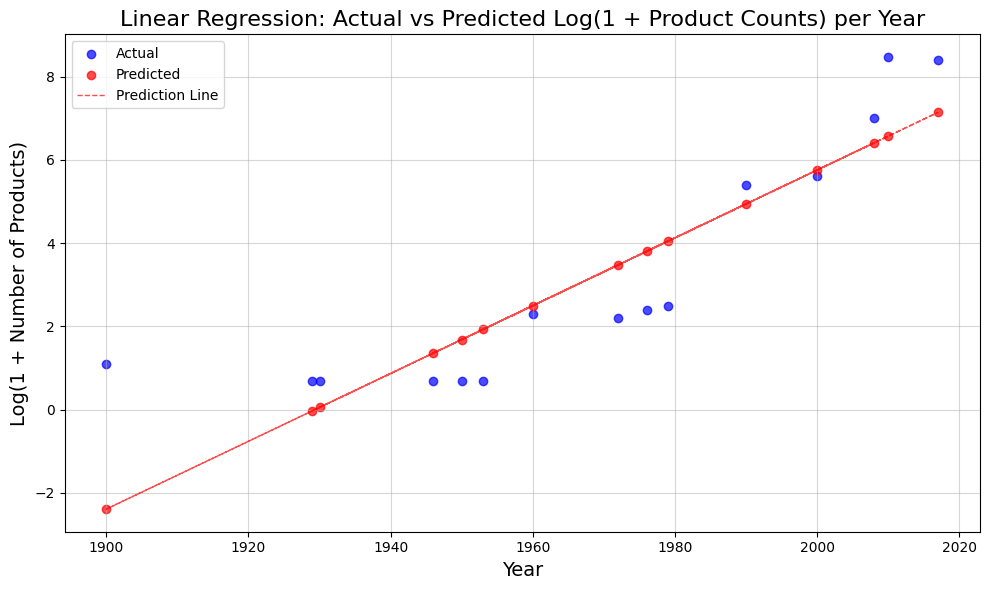

Intercept: -157.13
Coefficient (slope): 0.08


In [111]:
#Preparing data again
products_per_year_df = products_per_year.reset_index()  # Resetting index
products_per_year_df.columns = ['Year', 'Product_Count']  # Renaming columns

#Apply log transformation
products_per_year_df['Log_Product_Count'] = np.log1p(products_per_year_df['Product_Count'])

#Log-transformed data for the dependent variable (y)
X = products_per_year_df[['Year']]  # Independent variable
y = products_per_year_df['Log_Product_Count']  # Dependent variable

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  #80% train, 20% test

#Train the model
model = LinearRegression()
model.fit(X_train, y_train)

#Make Predictions
y_pred = model.predict(X_test)

#Evaluate the model using MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

#Visualize Actual vs Predicted Values (on log scale)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.7)
plt.plot(X_test, y_pred, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Prediction Line')
plt.title("Linear Regression: Actual vs Predicted Log(1 + Product Counts) per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Log(1 + Number of Products)", fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

#Display model coefficients
print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficient (slope): {model.coef_[0]:.2f}")

#Reverse log transform to make it interpretable
y_pred_original_scale = np.expm1(y_pred)

Using the log-transformed model will make a good representation for the Stream Lit app! 

**Exploring the Marketing Category of OTC Drug Products**

Look at the marketing category of the OTC Drug Products: 

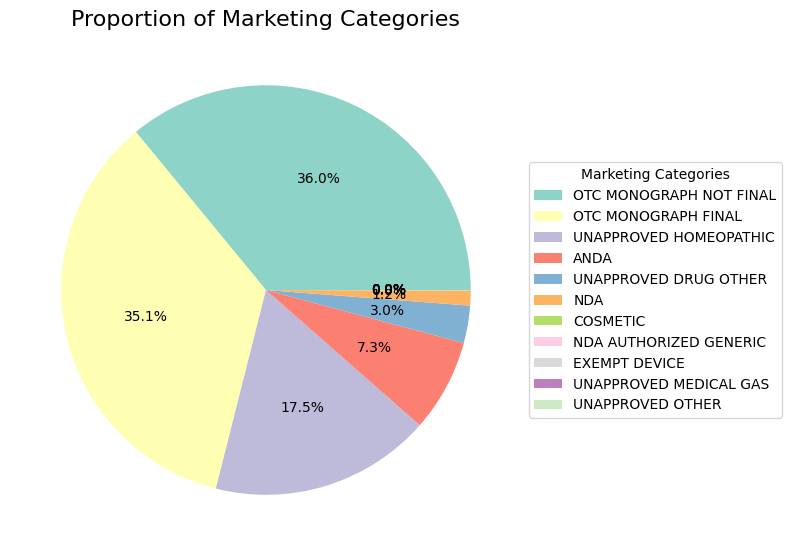

In [112]:
#Counts of Each Marketing Category
marketing_counts = df_filtered['MARKETINGCATEGORYNAME'].value_counts()

#Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(marketing_counts, labels=None, autopct='%1.1f%%', colors=sns.color_palette("Set3", n_colors=len(marketing_counts)))

#Add a legend
plt.legend(marketing_counts.index, title="Marketing Categories", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Proportion of Marketing Categories', fontsize=16)
plt.tight_layout()  # To ensure the plot fits well when saving or showing
plt.show()

While this is a cool visual, don't think this is particularly interesting for most people (as I am in regulatory, it was mostly for my interest)

**Dosage Form and Route of Administration Exploration**

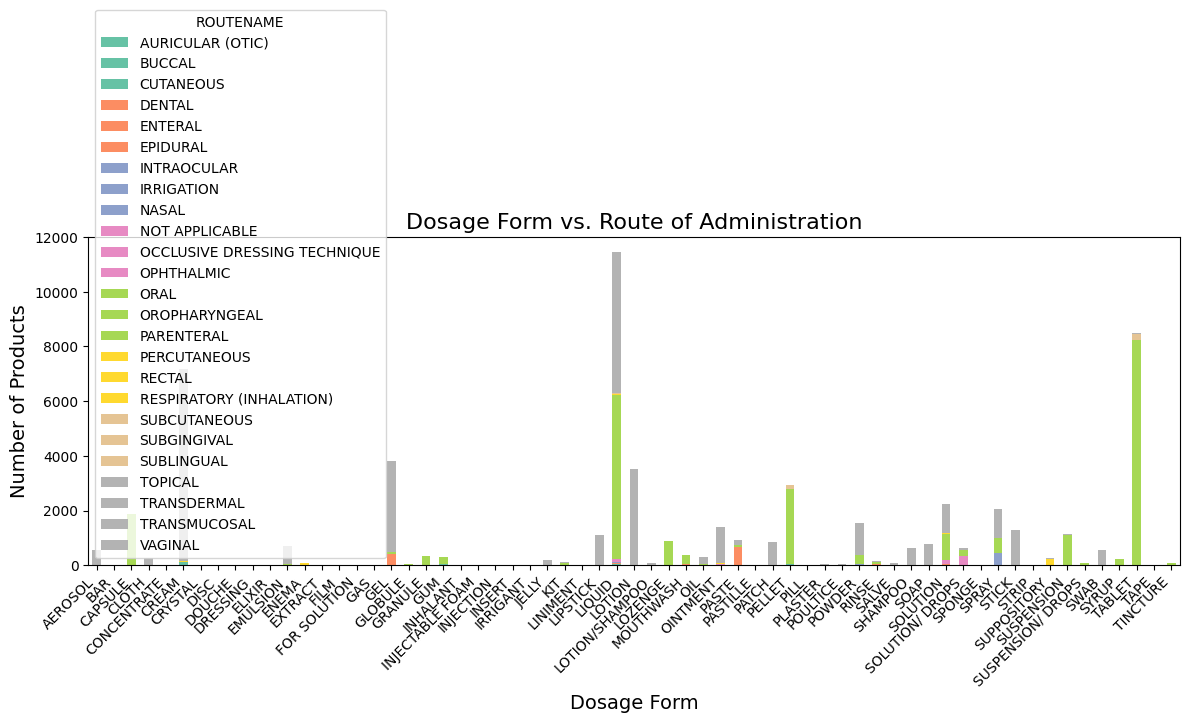

In [113]:
#Counts for Dosage Form and Route Name
dosage_route_counts = pd.crosstab(df_filtered['DOSAGEFORMNAME'], df_filtered['ROUTENAME'])

#Get the number of unique dosage forms and routes so plot can dynamic update
num_dosage_forms = len(dosage_route_counts.index)  # Number of unique dosage forms
num_routes = len(dosage_route_counts.columns)  # Number of unique routes

#Dynamically adjust figsize based on the data
figsize = (min(12, num_dosage_forms * 0.5), min(6, num_routes * 0.5))

#plot the data
dosage_route_counts.plot(kind='bar', stacked=True, figsize=figsize, colormap="Set2")
plt.xlabel('Dosage Form', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.title('Dosage Form vs. Route of Administration', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



This above plot is not helpful. Try a Sankey?

In [114]:
# Counts for Dosage Form and Route Name
dosage_route_counts = pd.crosstab(df_filtered['DOSAGEFORMNAME'], df_filtered['ROUTENAME'])

#Prepare the labels
labels = list(dosage_route_counts.index) + list(dosage_route_counts.columns)

#Prepare the source, target, and value lists
sources = []
targets = []
values = []

#Create the source, target, and value for Sankey diagram
for i, dosage_form in enumerate(dosage_route_counts.index):
    for j, route in enumerate(dosage_route_counts.columns):
        if dosage_route_counts.loc[dosage_form, route] > 0:
            sources.append(i)  # Index of the dosage form
            targets.append(len(dosage_route_counts.index) + j)  # Index of the route
            values.append(dosage_route_counts.loc[dosage_form, route])

#Create Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0,0,0,0.5)"  # Make the links semi-transparent
    )
))

#Layout
fig.update_layout(
    title="Sankey Diagram of Dosage Form vs. Route of Administration",
    font=dict(size=12),
    width=800,
    height=600
)

fig.write_html("sankey_plot.html")

Sankey is cool, but also not super useful! Let's look at the number of products per DOSAGEFORMNAME over time.

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/2742332572.py:15: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



<Figure size 1200x600 with 0 Axes>

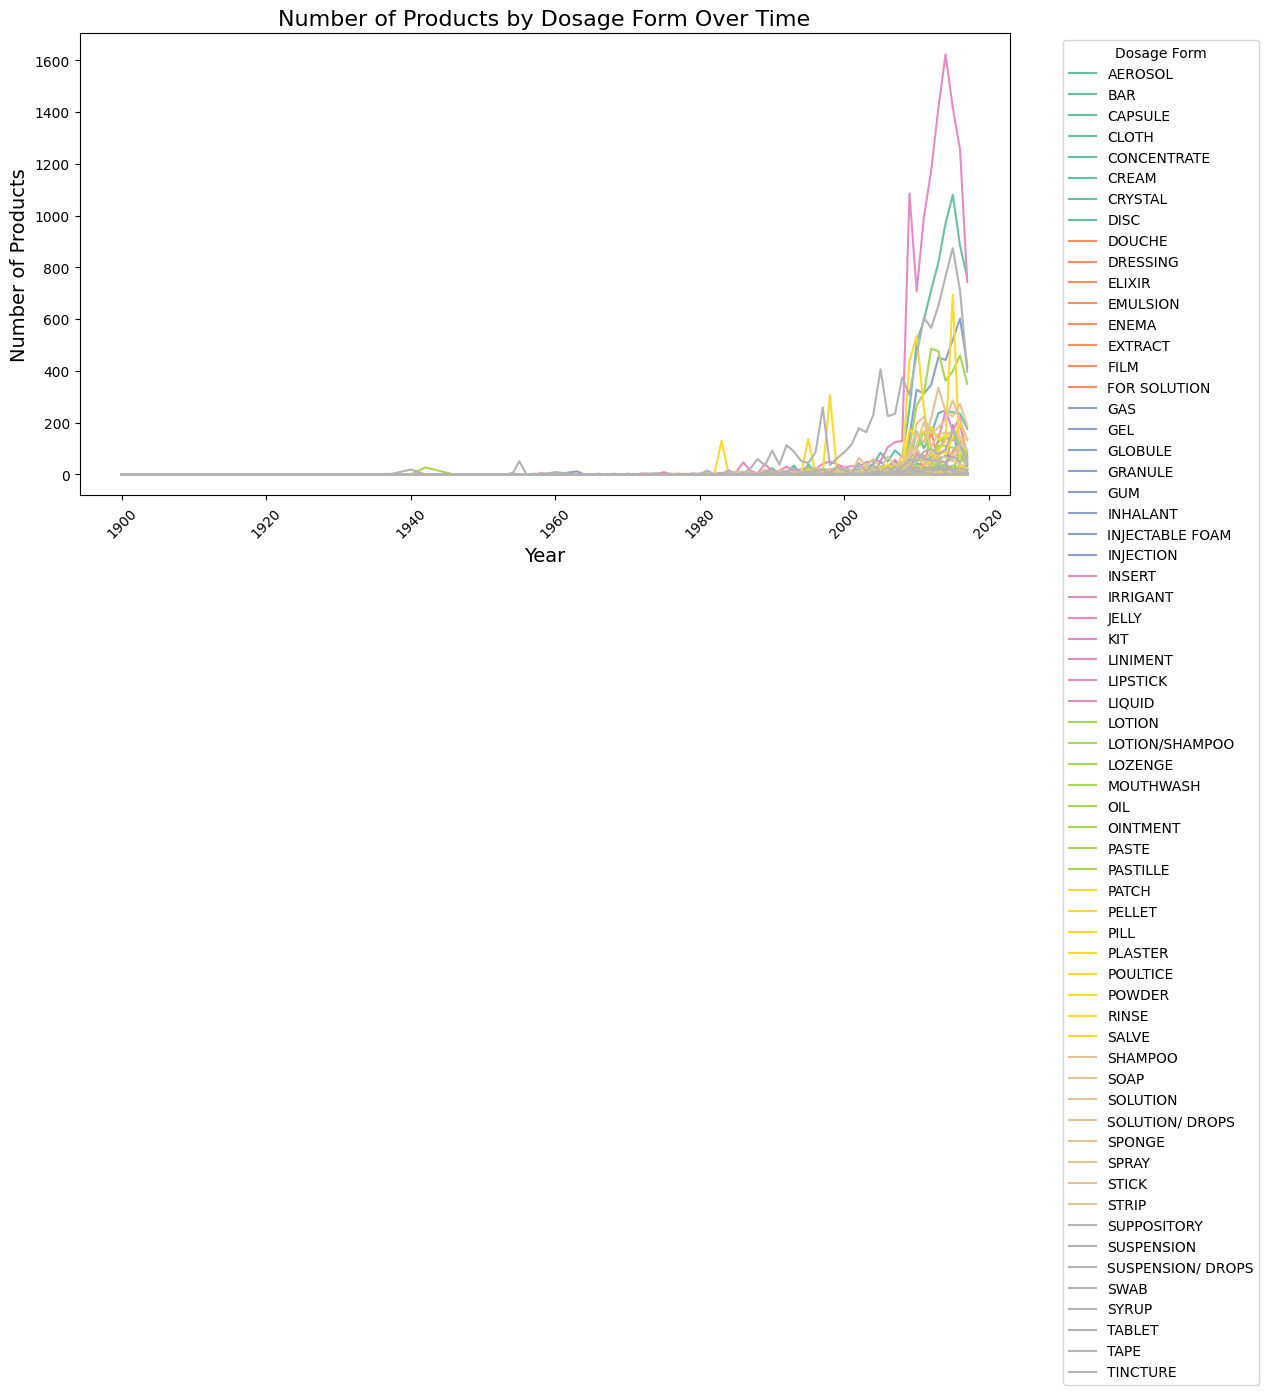

In [115]:
#Extract year from filter again
df_filtered['Year'] = pd.to_datetime(df_filtered['STARTMARKETINGDATE']).dt.year

#Group by Year and DOSAGEFORMNAME, then count the products
dosage_form_over_time = df_filtered.groupby(['Year', 'DOSAGEFORMNAME']).size().unstack(fill_value=0)

#Plot the data
plt.figure(figsize=(12, 6))
dosage_form_over_time.plot(kind='line', stacked=False, figsize=(12, 6), colormap="Set2")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.title('Number of Products by Dosage Form Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Dosage Form', bbox_to_anchor=(1.05, 1), loc='upper left')  # Display legend outside
plt.tight_layout()

plt.show()


Make this interactive:

In [116]:
import plotly.express as px

#Group by Year and Dosage Form Name, then count the products
dosage_form_over_time = df_filtered.groupby(['Year', 'DOSAGEFORMNAME']).size().reset_index(name='Product_Count')

#Create an interactive line plot
fig = px.line(dosage_form_over_time, 
              x='Year', 
              y='Product_Count', 
              color='DOSAGEFORMNAME', 
              title='Number of Products by Dosage Form Over Time', 
              labels={'Product_Count': 'Number of Products', 'Year': 'Year'},
              markers=True)  # Add markers to the lines

#Layout
fig.update_layout(
    title="Number of Products by Dosage Form Over Time",
    xaxis_title="Year",
    yaxis_title="Number of Products",
    legend_title="Dosage Form",
    xaxis=dict(tickmode='linear', dtick=1),  # Ensure yearly ticks
    template="plotly_dark"  # Optional, for a dark theme
)

#WRite to HTML for interactive plot
fig.write_html("dosageformplot.html")


To narrow this down further: let's look at the dosage forms over all time to find the top 3 dosage forms. 

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/1386452881.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




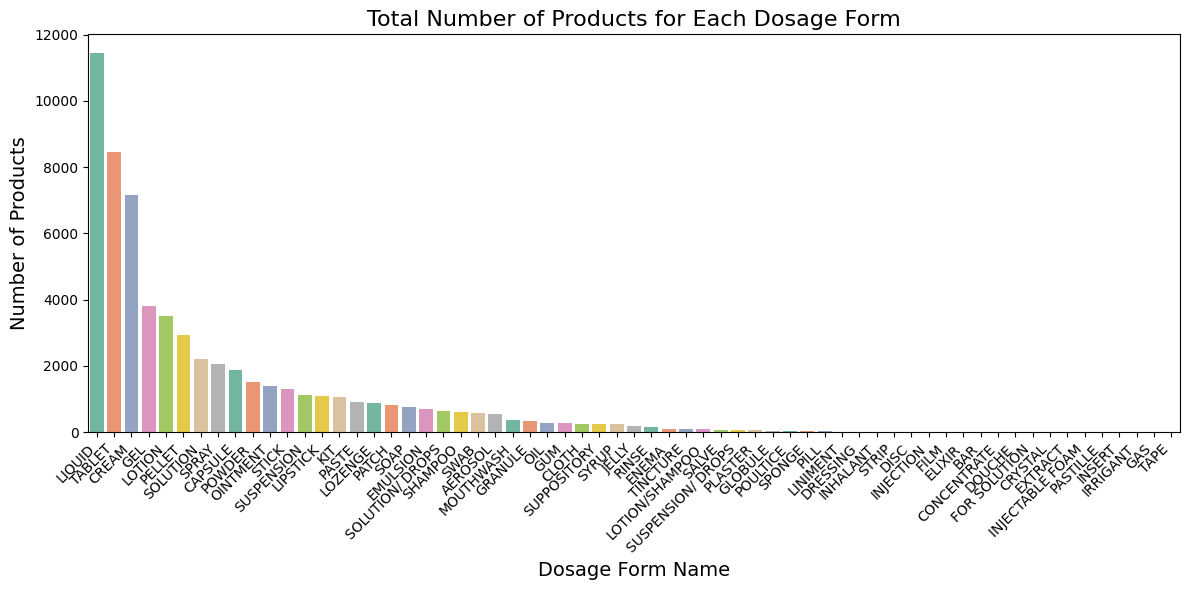

In [117]:
#Count the total number of products for each Dosage Form Name
dosage_form_counts = df_filtered['DOSAGEFORMNAME'].value_counts()

#Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x=dosage_form_counts.index, y=dosage_form_counts.values, palette='Set2')
plt.xlabel('Dosage Form Name', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.title('Total Number of Products for Each Dosage Form', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Automatically adjusts layout to prevent clipping
plt.show()


Top 3 are: liquid, tablet, cream. Let's now do a plot over time for each of these individually. 

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/1512051622.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/1512051622.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/1512051622.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

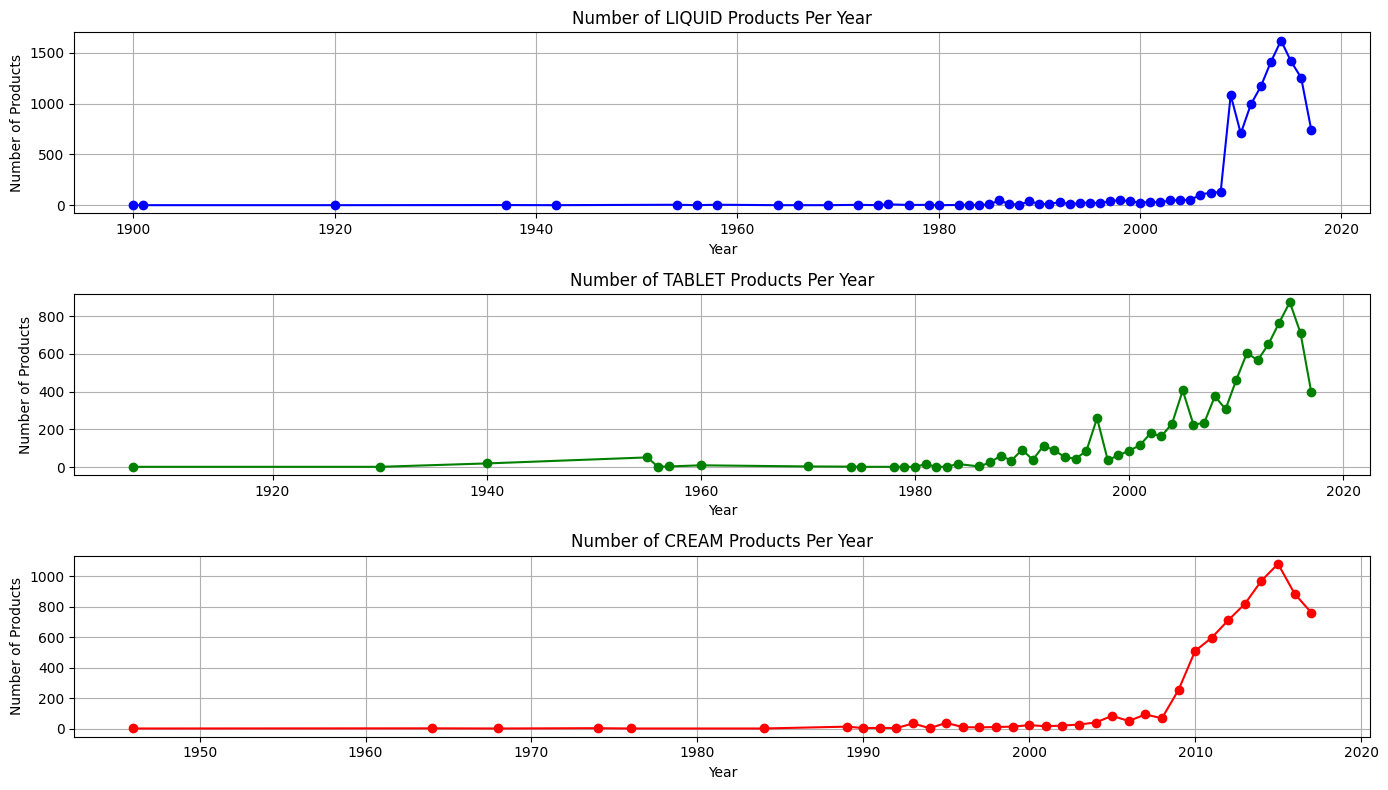

In [118]:
#Filter the data
liquid_df = df_filtered[df_filtered['DOSAGEFORMNAME'] == 'LIQUID']
tablet_df = df_filtered[df_filtered['DOSAGEFORMNAME'] == 'TABLET']
cream_df = df_filtered[df_filtered['DOSAGEFORMNAME'] == 'CREAM']

#Extract the year
liquid_df['Year'] = liquid_df['STARTMARKETINGDATE'].dt.year
tablet_df['Year'] = tablet_df['STARTMARKETINGDATE'].dt.year
cream_df['Year'] = cream_df['STARTMARKETINGDATE'].dt.year

#Count the number of products per year for each dosage form
liquid_per_year = liquid_df.groupby('Year').size()
tablet_per_year = tablet_df.groupby('Year').size()
cream_per_year = cream_df.groupby('Year').size()

#Plotting
plt.figure(figsize=(14, 8))

# Plot for LIQUID
plt.subplot(3, 1, 1)
plt.plot(liquid_per_year.index, liquid_per_year.values, marker='o', color='blue', label='LIQUID')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('Number of LIQUID Products Per Year')
plt.grid(True)

# Plot for TABLET
plt.subplot(3, 1, 2)
plt.plot(tablet_per_year.index, tablet_per_year.values, marker='o', color='green', label='TABLET')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('Number of TABLET Products Per Year')
plt.grid(True)

# Plot for CREAM
plt.subplot(3, 1, 3)
plt.plot(cream_per_year.index, cream_per_year.values, marker='o', color='red', label='CREAM')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('Number of CREAM Products Per Year')
plt.grid(True)


plt.tight_layout()
plt.show()


Similarly to the original plot on "Number of Products Introduced per Year", the following section will use linear regression modeling for prediction. 

Mean Squared Error: 172349.07868251437
Mean Squared Error: 61770.66661530665
Mean Squared Error: 62420.38555967222


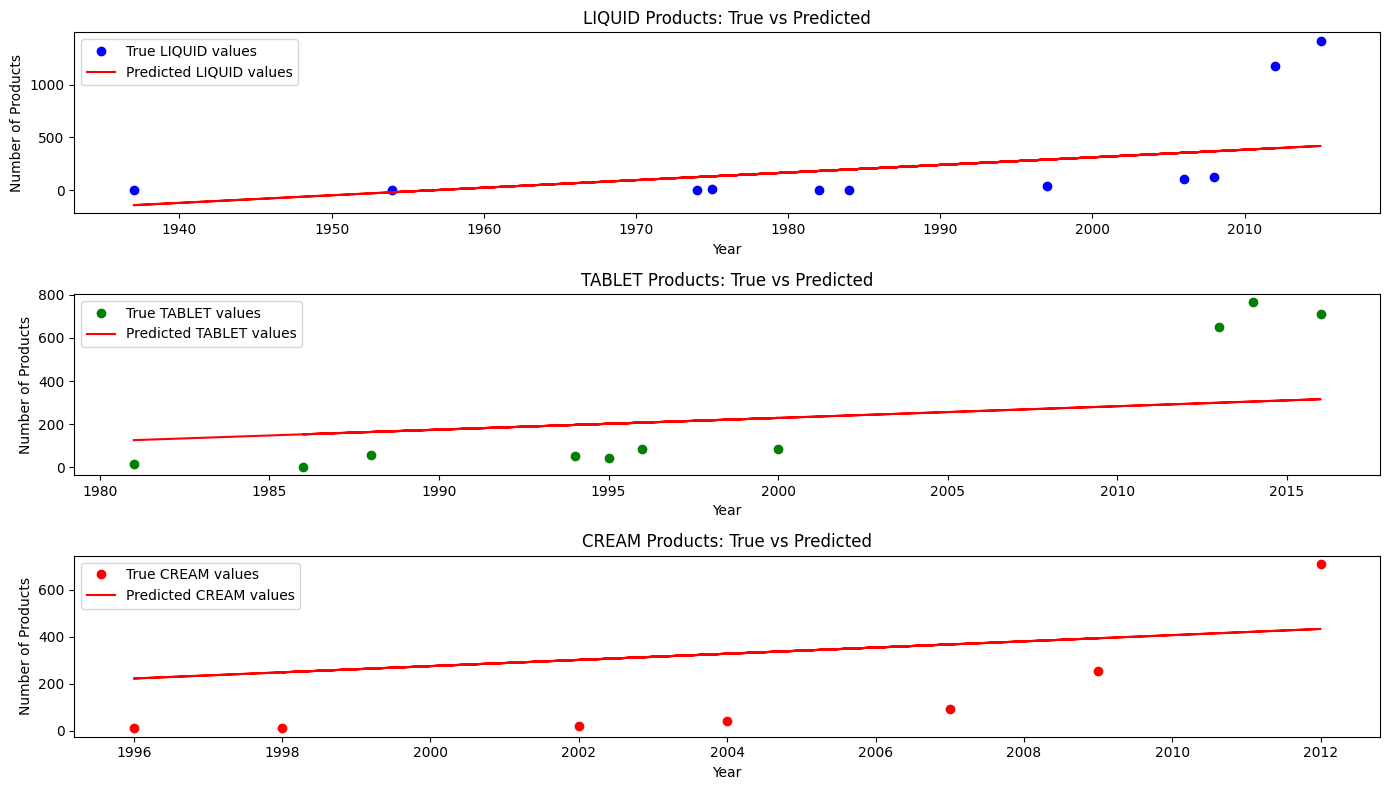

In [119]:
#Filter the data for relevant product types
df_filtered = df_filtered[df_filtered['DOSAGEFORMNAME'].isin(['LIQUID', 'TABLET', 'CREAM'])]

#Extract the year from the STARTMARKETINGDATE
df_filtered['Year'] = df_filtered['STARTMARKETINGDATE'].dt.year

#Group data by Year and DOSAGEFORMNAME, counting the number of products per year for each type
product_counts = df_filtered.groupby(['Year', 'DOSAGEFORMNAME']).size().reset_index(name='Product_Count')

#Split the data for each product type
liquid_df = product_counts[product_counts['DOSAGEFORMNAME'] == 'LIQUID']
tablet_df = product_counts[product_counts['DOSAGEFORMNAME'] == 'TABLET']
cream_df = product_counts[product_counts['DOSAGEFORMNAME'] == 'CREAM']

#Train Linear Regression Model for each product type
#Function to train and predict for each product type
def train_predict_model(df):
    X = df[['Year']] #Independent variable
    y = df['Product_Count']  #Dependent variable
    
    #Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #Make predictions
    y_pred = model.predict(X_test)
    
    #Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    
    return model, X_test, y_test, y_pred

#Train and predict for LIQUID
liquid_model, X_test_liquid, y_test_liquid, y_pred_liquid = train_predict_model(liquid_df)

#Train and predict for TABLET
tablet_model, X_test_tablet, y_test_tablet, y_pred_tablet = train_predict_model(tablet_df)

#Train and predict for CREAM
cream_model, X_test_cream, y_test_cream, y_pred_cream = train_predict_model(cream_df)

#Plot for LIQUID
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(X_test_liquid, y_test_liquid, 'bo', label='True LIQUID values')
plt.plot(X_test_liquid, y_pred_liquid, 'r-', label='Predicted LIQUID values')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('LIQUID Products: True vs Predicted')
plt.legend()

#Plot for TABLET
plt.subplot(3, 1, 2)
plt.plot(X_test_tablet, y_test_tablet, 'go', label='True TABLET values')
plt.plot(X_test_tablet, y_pred_tablet, 'r-', label='Predicted TABLET values')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('TABLET Products: True vs Predicted')
plt.legend()

#Plot for CREAM
plt.subplot(3, 1, 3)
plt.plot(X_test_cream, y_test_cream, 'ro', label='True CREAM values')
plt.plot(X_test_cream, y_pred_cream, 'r-', label='Predicted CREAM values')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.title('CREAM Products: True vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

Similarly to the original plot on "Number of Products Introduced per Year", the above plots need to use the log in order to account for skewed numbers. 

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/3028033665.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/3028033665.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fy/28gjq6j94pvgx78r45rd734h0000gn/T/ipykernel_8392/3028033665.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Mean Squared Error (log-transformed): 2.599975098753327
Mean Squared Error (log-transformed): 0.9570430162362001
Mean Squared Error (log-transformed): 0.8478286442756594


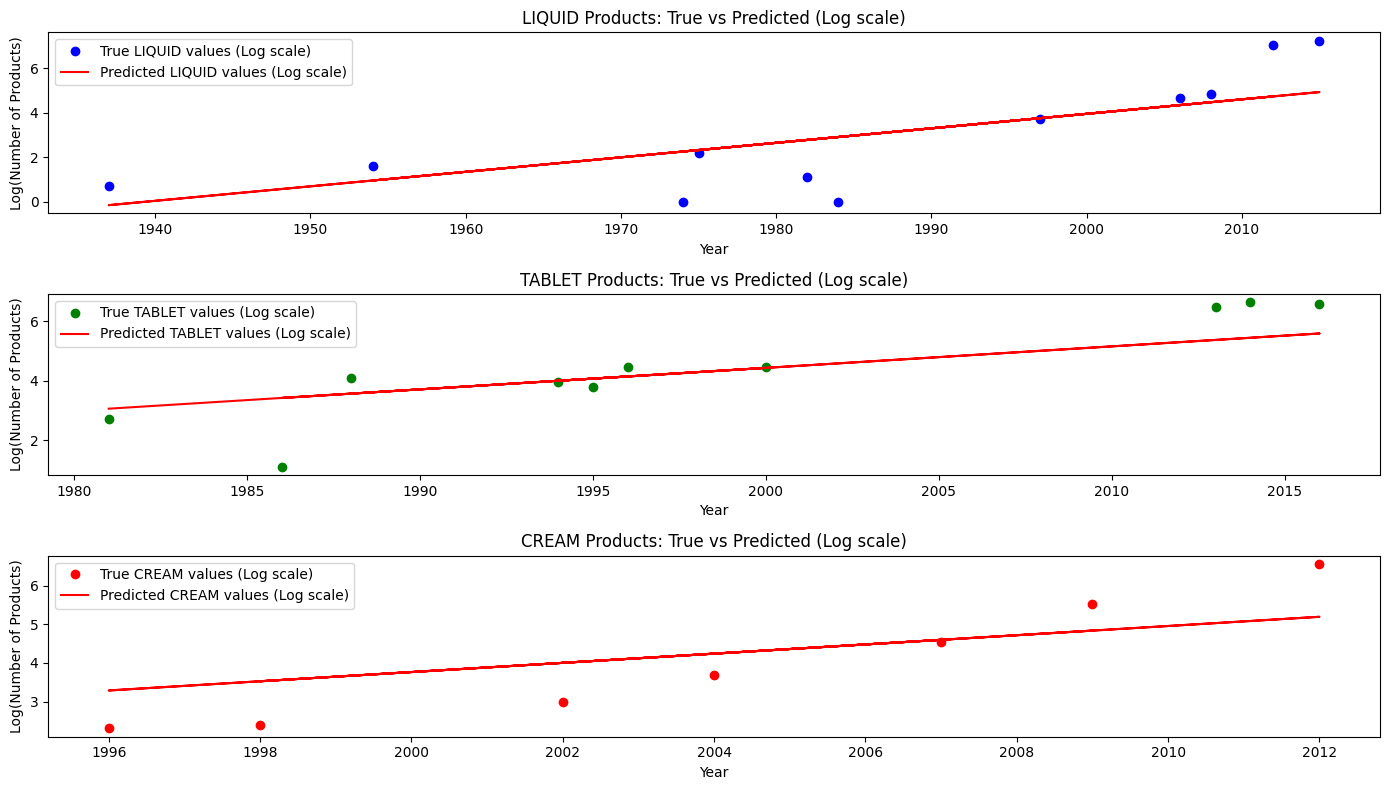

Predicted LIQUID Products (Original Scale): [ 17.31908602  76.15286622 113.197379     8.52935887  86.92656126
   1.57859683  15.07443727 137.93388247  -0.15110253  41.84458665
   9.17296838]
Predicted TABLET Products (Original Scale): [ 20.24143175 230.19324255 266.18432491 214.05879914  29.49814219
  61.87132046  57.48367595  53.40223503  82.97002075  34.24595028]
Predicted CREAM Products (Original Scale): [125.27851879  25.77659322  98.47242041  68.54445294  32.99242238
 179.62159351  53.78172477]


In [120]:
#Log-transform the Product_Count
liquid_df['Log_Product_Count'] = np.log(liquid_df['Product_Count'])
tablet_df['Log_Product_Count'] = np.log(tablet_df['Product_Count'])
cream_df['Log_Product_Count'] = np.log(cream_df['Product_Count'])

#Function to train and predict for each product type with log-transformed values
def train_predict_log_model(df):
    X = df[['Year']]  # Independent variable
    y = df['Log_Product_Count']  # Dependent variable
    
    #Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #Make predictions
    y_pred = model.predict(X_test)
    
    #Evaluate the model using log-transformed MSE
    mse = mean_squared_error(y_test, y_pred)  # Use log-transformed y_test for comparison
    print(f'Mean Squared Error (log-transformed): {mse}')
    
    return model, X_test, y_test, y_pred

#Train and predict for LIQUID with log transformation
liquid_model, X_test_liquid, y_test_liquid, y_pred_liquid = train_predict_log_model(liquid_df)

#Train and predict for TABLET with log transformation
tablet_model, X_test_tablet, y_test_tablet, y_pred_tablet = train_predict_log_model(tablet_df)

#Train and predict for CREAM with log transformation
cream_model, X_test_cream, y_test_cream, y_pred_cream = train_predict_log_model(cream_df)

#Plot for LIQUID (on log scale)
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(X_test_liquid, y_test_liquid, 'bo', label='True LIQUID values (Log scale)')  # True values on log scale
plt.plot(X_test_liquid, y_pred_liquid, 'r-', label='Predicted LIQUID values (Log scale)')  # Predicted values on log scale
plt.xlabel('Year')
plt.ylabel('Log(Number of Products)')
plt.title('LIQUID Products: True vs Predicted (Log scale)')
plt.legend()

#Plot for TABLET (on log scale)
plt.subplot(3, 1, 2)
plt.plot(X_test_tablet, y_test_tablet, 'go', label='True TABLET values (Log scale)')  # True values on log scale
plt.plot(X_test_tablet, y_pred_tablet, 'r-', label='Predicted TABLET values (Log scale)')  # Predicted values on log scale
plt.xlabel('Year')
plt.ylabel('Log(Number of Products)')
plt.title('TABLET Products: True vs Predicted (Log scale)')
plt.legend()

#Plot for CREAM (on log scale)
plt.subplot(3, 1, 3)
plt.plot(X_test_cream, y_test_cream, 'ro', label='True CREAM values (Log scale)')  # True values on log scale
plt.plot(X_test_cream, y_pred_cream, 'r-', label='Predicted CREAM values (Log scale)')  # Predicted values on log scale
plt.xlabel('Year')
plt.ylabel('Log(Number of Products)')
plt.title('CREAM Products: True vs Predicted (Log scale)')
plt.legend()

plt.tight_layout()
plt.show()

#Reverse log transform to make it interpretable (after the plots)
y_pred_liquid_original_scale = np.expm1(y_pred_liquid)
y_pred_tablet_original_scale = np.expm1(y_pred_tablet)
y_pred_cream_original_scale = np.expm1(y_pred_cream)

# Now y_pred values are on the original scale and can be interpreted
print("Predicted LIQUID Products (Original Scale):", y_pred_liquid_original_scale)
print("Predicted TABLET Products (Original Scale):", y_pred_tablet_original_scale)
print("Predicted CREAM Products (Original Scale):", y_pred_cream_original_scale)

While these predictions are still quite low (from the predicted values), given that the model is linear regression model, it is doing fairly decent. Underestimating the numbers perhaps. However, this would make a fun app, in which the user can input:
1) a year
2) product type: liquid, tablet, and cream

The app will output a predicted number of OTC Drug Products in that product type category and year. 

See ADevin_Capstone.py for the app itself.